# Clasificación de preguntas de clientes

https://metadata.fundacionsadosky.org.ar/competition/21/

## Introducción
Novedades:

Informes, fechas y formatos: ver sección evaluación.

La gente de Santander Tecnología nos compartío un baseline para que puedan seguir explorando o tengan un punto de partida para esta competencia.

En Santander tenemos por misión contribuir al progreso de las personas y las empresas. Debido a ello buscamos constantemente nuevas formas de entender al cliente, con el objetivo de consolidar vínculos a largo plazo.

Nuestro equipo de Advanced Analytics & Machine Learning se encuentra en continua mejora de sus algoritmos y modelos. Basándonos en esta premisa, decidimos abrir nuestros datos e invitar a la comunidad a identificar nuevas formas de entender las preguntas y reclamos de nuestros clientes, utilizando un motor de NLU (Natural Language Understanding).

Esta competencia tiene como objetivo desarrollar un algoritmo de clasificación que, utilizando técnicas de NLP (Natural Language Processing), sea capaz de entender la intención de un cliente (target) al momento de realizar una pregunta (predictor) en alguno de los canales del Banco.

## Descripción
Se disponen de tres datasets:

training.csv: reúne la información del caso, el mismo tiene dos columnas
    
    Pregunta: pregunta realizada por el cliente. (String)

    Intención: intención de la pregunta realizada, contiene 350 intenciones aproximadamente. (String)

test.csv: solo contiene la pregunta realizada por el cliente.

primer_submit.csv: este archivo tiene el formato en el que se deben enviar las predicciones.

## Evaluación
La evaluación consta de dos partes:

1 - Score de predicciones: los resultados serán medidos utilizando la métrica Balance Accuracy.
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html En el leaderboard se puede ver el mejor score público del total de submits de cada participante. El mismo se calcula con una porción de los datos de test. Metadata se reserva el score privado para la evaluación final.

El archivo con predicciones que se debe submitear debe esta en formato csv sin encabezado y debe contar de dos columnas. La primer columna corresponde al 'id' de la pregunta hecha por el cliente en el archivo de test. La segunda a la categoría predicha en formato de entero, es decir, si la predicción es cat_101 (string) debe reportar solamente 101 (int). Para ver un ejemplo puede mirar el archivo primer_submit en las solapa Datos.

2 - Informe: Al finalizar la competencia se pedirá a los primeros 10 competidores en el ranking de predicciones un informe adicional, donde se explique el modelo y la metodología aplicada. La nota la otorgará un jurado ad-hoc de especialistas en el tema evaluando el informe sobre el trabajo realizado con el análisis de contrastación entre los datos reales y los datos generados por los modelos.

Finalmente, el score total que determinará los ganadores se compondrá en un 70% por el score privado conseguido con la predicción medida con la métrica especificada y el 30% restante se sumará con el informe.

Importante: tanto Santander como Metadata se reservan el derecho a pedir el código para poder evaluar el modelo y evitar soluciones tramposas. En caso de que se le requiera el código a un participante y no lo envíe, será descalificado de forma inmediata.

Informe
Los primeros 10 participantes en el ranking deben entregar un informe para definir los ganadores. El período para entregar el informe es del 11/7/2020 al 17/7/2020 (inclusive). Se debe enviar un mail a metadata@fundacionsadosky.org.ar que contenga:

Encabezado: competencia SANTANDER 2020 informe.
Un archivo adjunto con el informe. El nombre del archivo debe ser su nombre de usuario, por ejemplo "datosky.zip". En caso de necesitar mandar más de un archivo utilizar algún sistema de compresión.
En el cuerpo del mail pueden escribir lo que gusten, aunque si quieren expresar alguna cuestión relacionada al informe ponerlo en el informe o crear un archivo "readme.txt".
Por favor les pedimos que respeten el formato

Guía
Pueden entregar el informe en el formato que gusten. Es obligatorio entregar el código que valide su solución. A continuación les dejamos una guía que seguramente los ayudará a sumar más puntos:

De más deseable a menos deseable:

Notebook (Jupyter).
PDF.
Contenido

Descripción del proceso, desde que ingresan hasta que salen los datos (¿Se hizo limpieza de datos?, ¿En base a qué?, ¿Qué usaron?, etc).
Principales hallazgos del proceso analítico
Algoritmos utilizados y ¿Por qué la elección de los mismos?
¿Qué métodos utilizaron para lograr la mejor selección de hyperparametros?
Próximos pasos / posibles mejoras / si hubieras tenido más tiempo/recursos, ¿Qué hubieras hecho diferente?
¿Qué valor agrega tu solución?


# Carga de datos

In [1]:
# Librerías a utilizar
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Levanto el archivo
data = pd.read_csv('train.csv', sep='|')

In [3]:
data

,Pregunta,Intencion
0,como puedo trabajar en santander rio,Cat_102
1,pagar tarjeta visa querer reintegro,Cat_350
2,pagar tarjeta naranja sistema,Cat_132
3,no se debitó la primera cuota del plan de bien...,Cat_129
4,abonar tarjeta credito,Cat_342
...,...,...
20099,el monto del prestamo depende de los ingresos???,Cat_251
20100,quiero cancelar una compra puntual el cuotas,Cat_339
20101,necesito pagar deuda,Cat_192
20102,teniendo otro hipotecario es posible aplicar p...,Cat_218


# Análisis Exploratorio

In [4]:
# Cantidad de categorías de Intencion
data['Intencion'].nunique()

352

In [5]:
categorias = data['Intencion'].unique()

In [6]:
# Contar la cantidad de repeticiones de cada categoría de Intencion
preguntas_por_categoria = data.groupby('Intencion').nunique()
preguntas_por_categoria = preguntas_por_categoria.drop(columns='Intencion')

preguntas_por_categoria = preguntas_por_categoria.rename(columns={'Pregunta': 'cantidad_respuestas'})
preguntas_por_categoria
preguntas_por_categoria.sort_values(by='cantidad_respuestas', ascending=False)

,cantidad_respuestas
Intencion,
Cat_132,379
Cat_293,355
Cat_1,306
Cat_223,304
Cat_147,304
...,...
Cat_205,3
Cat_15,3
Cat_11,3


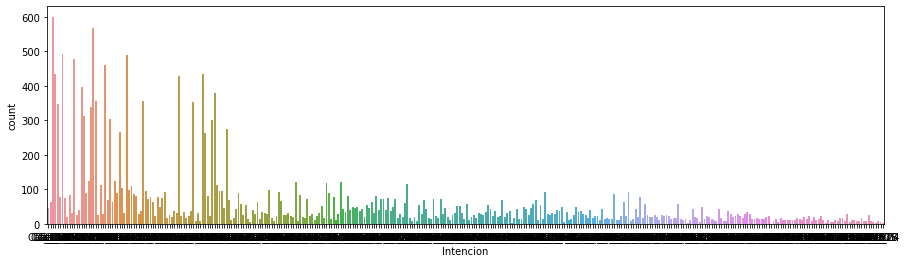

In [7]:
# Hacer un barplot de cantidad de respuestas por cada categoría
plt.figure(figsize=(15,4))
ax = sns.countplot(x="Intencion", data=data)

## Comentario 
Hay gran desbalance de cantidad de respuestas  entre categorías. Debería hacer undersampling?

In [8]:
# Hacer un boxplot con la cantidad de palabras por respuesta en cada categoría
largo_de_respuesta = dict()


largo_de_respuesta

{}

In [9]:
data['letras_por_pregunta'] = data['Pregunta'].str.len()
data

,Pregunta,Intencion,letras_por_pregunta
0,como puedo trabajar en santander rio,Cat_102,36
1,pagar tarjeta visa querer reintegro,Cat_350,35
2,pagar tarjeta naranja sistema,Cat_132,29
3,no se debitó la primera cuota del plan de bien...,Cat_129,82
4,abonar tarjeta credito,Cat_342,22
...,...,...,...
20099,el monto del prestamo depende de los ingresos???,Cat_251,48
20100,quiero cancelar una compra puntual el cuotas,Cat_339,44
20101,necesito pagar deuda,Cat_192,20
20102,teniendo otro hipotecario es posible aplicar p...,Cat_218,60


In [10]:
data['Intencion_cod'] = data['Intencion'].astype(str).str[4:]
data

,Pregunta,Intencion,letras_por_pregunta,Intencion_cod
0,como puedo trabajar en santander rio,Cat_102,36,102
1,pagar tarjeta visa querer reintegro,Cat_350,35,350
2,pagar tarjeta naranja sistema,Cat_132,29,132
3,no se debitó la primera cuota del plan de bien...,Cat_129,82,129
4,abonar tarjeta credito,Cat_342,22,342
...,...,...,...,...
20099,el monto del prestamo depende de los ingresos???,Cat_251,48,251
20100,quiero cancelar una compra puntual el cuotas,Cat_339,44,339
20101,necesito pagar deuda,Cat_192,20,192
20102,teniendo otro hipotecario es posible aplicar p...,Cat_218,60,218


Text(0.5, 1.0, 'cantidad de palabras por pregunta')

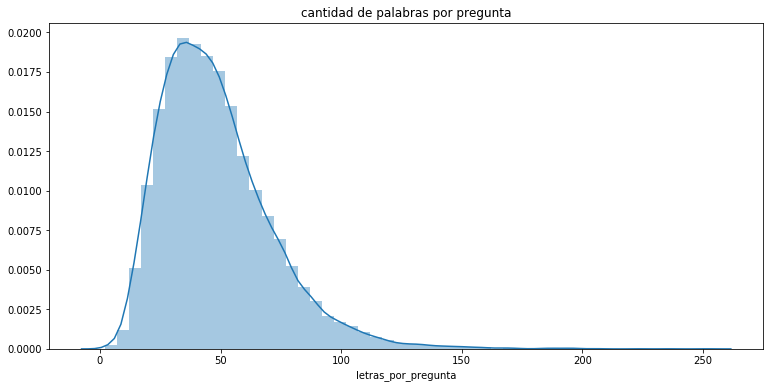

In [11]:
plt.figure(figsize=(12.8,6))
sns.distplot(data['letras_por_pregunta']).set_title("cantidad de palabras por pregunta")

In [12]:
data['letras_por_pregunta'].describe()

count    20104.000000
mean        48.142310
std         23.282199
min          2.000000
25%         31.000000
50%         44.000000
75%         60.000000
max        252.000000
Name: letras_por_pregunta, dtype: float64

In [13]:
# Cuales son las 2 palabras más utilizadas en cada categoría


# Feature Engineering

## Caracteres especiales

In [14]:
# Elimino los caracteres especiales
data['Pregunta'] = data['Pregunta'].str.replace("\r", " ")
data['Pregunta'] = data['Pregunta'].str.replace("\n", " ")
data['Pregunta'] = data['Pregunta'].str.replace("  ", " ")

## Signos de puntuación

In [15]:
# Elimino los signos de puntuación
puntuaciones = list("?:!.,;")
for puntuacion in puntuaciones:
    data['Pregunta'] = data['Pregunta'].str.replace(puntuacion, '')

## Lowercase

In [16]:
# Me aseguro que todas las palabras están en lowercase
data['Pregunta'] = data['Pregunta'].str.lower()

## Lemmatization

In [17]:
from pattern.es import parsetree



## Stopwords

In [18]:
import nltk
from nltk.corpus import stopwords
stops=set(stopwords.words('spanish'))
stops

{'a',
 'al',
 'algo',
 'algunas',
 'algunos',
 'ante',
 'antes',
 'como',
 'con',
 'contra',
 'cual',
 'cuando',
 'de',
 'del',
 'desde',
 'donde',
 'durante',
 'e',
 'el',
 'ella',
 'ellas',
 'ellos',
 'en',
 'entre',
 'era',
 'erais',
 'eran',
 'eras',
 'eres',
 'es',
 'esa',
 'esas',
 'ese',
 'eso',
 'esos',
 'esta',
 'estaba',
 'estabais',
 'estaban',
 'estabas',
 'estad',
 'estada',
 'estadas',
 'estado',
 'estados',
 'estamos',
 'estando',
 'estar',
 'estaremos',
 'estará',
 'estarán',
 'estarás',
 'estaré',
 'estaréis',
 'estaría',
 'estaríais',
 'estaríamos',
 'estarían',
 'estarías',
 'estas',
 'este',
 'estemos',
 'esto',
 'estos',
 'estoy',
 'estuve',
 'estuviera',
 'estuvierais',
 'estuvieran',
 'estuvieras',
 'estuvieron',
 'estuviese',
 'estuvieseis',
 'estuviesen',
 'estuvieses',
 'estuvimos',
 'estuviste',
 'estuvisteis',
 'estuviéramos',
 'estuviésemos',
 'estuvo',
 'está',
 'estábamos',
 'estáis',
 'están',
 'estás',
 'esté',
 'estéis',
 'estén',
 'estés',
 'fue',
 'f

## Separar train y test

In [19]:
X = data['Pregunta']
y = data['Intencion_cod']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 12)

In [20]:
print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(X_test.shape)

(4021,)
(4021,)
(16083,)
(4021,)



# Predicción

In [127]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(stop_words=stops)
# vectorizer.fit(X_train)
# X_train = vectorizer.transform(X_train)
# X_test = vectorizer.transform(X_test)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Parameter election
min_df = 10
max_df = 1.
max_features = 100

vectorizer = TfidfVectorizer(
#                         encoding='utf-8',
                        ngram_range=(1,1),
                        stop_words=stops,
#                         lowercase=False,
#                         max_df=max_df,
#                         min_df=min_df,
#                         max_features=max_features,
#                         norm='l2',
#                         sublinear_tf=True
                            )


vectorizer.fit(X_train)

X_train_vector = vectorizer.transform(X_train)
y_train_vector = y_train

X_test_vector = vectorizer.transform(X_test)
y_test_vector = y_test

print('X_train_vector')
print(X_train_vector.shape)
print(type(X_train_vector))
print('X_test_vector')
print(X_test_vector.shape)
print(type(X_test_vector))

X_train_vector
(16083, 5636)
<class 'scipy.sparse.csr.csr_matrix'>
X_test_vector
(4021, 5636)
<class 'scipy.sparse.csr.csr_matrix'>


In [22]:
X_train

2301         no encuentro donde pedir la tarjeta adicional
8393                    querer actualizar contraseña deber
6520                        quisira dar de alta mi tarjeta
3074     solicitar la tarjeta de debito con chip porque...
19885    quisiera saber en cuanto esta la compra de dol...
                               ...                        
3714                        querer obtener clave reconocer
7409     me contacto ya que quiero solicitar la baja de...
19709                              consultar dudar debitar
5787     necesito con urgencia un resumen de cuenta del...
14155    quiero saber el tiempo estimado para recibir m...
Name: Pregunta, Length: 16083, dtype: object

In [23]:
X_train_vector

<16083x5636 sparse matrix of type '<class 'numpy.float64'>'
	with 76838 stored elements in Compressed Sparse Row format>

In [24]:
y_train_vector

2301     334
8393       1
6520     301
3074     316
19885    166
        ... 
3714       1
7409     338
19709    115
5787     138
14155     45
Name: Intencion_cod, Length: 16083, dtype: object

## Support Vector Machines

In [29]:
from sklearn.model_selection import GridSearchCV #importo GridSearch
from sklearn.svm import LinearSVC #importo Linear Support Vector Machines

#Fijo los parámetros de Linear SVC para que Grid Search combine y evalue 
parameters = {'C':[0.01, 0.1, 1],
                'loss':['hinge', 'squared_hinge']}

linearsvc = LinearSVC() #defino la variable con el modelo a utilizar
#cargo grid_search con el modelo (linearsvc), el diccionario con los parámetros del SVC a evaluar (param_grid), CV=5 para que realice 5 cortes en la información a entrenar, scoring define el modo de evaluar el gridsearch con el área bajo la curva, return_train_score devuelve los resultados del train
grid_search = GridSearchCV(linearsvc, param_grid= parameters, cv=3, return_train_score=True) 
#Finalmente entreno el modelo con X_Train (todas las reviews en forma de matriz) e y_train (las valoraciones de cada una de las reviews 0=neg y 1=positivas)
grid_search.fit(X_train_vector, y_train_vector)


C:\Users\pamolteni\AppData\Local\Continuum\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\pamolteni\AppData\Local\Continuum\anaconda3\envs\ds\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1],
                         'loss': ['hinge', 'squared_hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [36]:
linsvc = grid_search.best_estimator_
linsvc

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [39]:
y_pred_linsvc = linsvc.predict(X_test_vector)
y_pred_linsvc

array(['228', '320', '322', ..., '186', '192', '279'], dtype=object)

## Random Forest

In [42]:
from sklearn.model_selection import GridSearchCV

# importo random forest
from sklearn.ensemble import RandomForestClassifier

# defino los parametros de random forest que incluiré en el GridSearchCV
parameters_gs_rf = {'n_estimators': [100, 500],
                    'max_depth': [3, 7],
                    'min_samples_split': [2, 3],
                    'bootstrap': [True, False],
                    'criterion': ["gini", "entropy"]}

#Cargo la variable clf_rm con Random Forest
clf_rf = RandomForestClassifier ()

#Cargo el grid search
grid_search_rf = GridSearchCV(clf_rf, param_grid= parameters_gs_rf, 
#                               scoring = 'roc_auc' ,
                              cv=5,
                              return_train_score=True) 

#entreno el grid_search con los valores de train
grid_search_rf.fit(X_train_vector, y_train_vector)

C:\Users\pamolteni\AppData\Local\Continuum\anaconda3\envs\ds\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [43]:
rf = grid_search_rf.best_estimator_
rf

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [45]:
y_pred_rf = rf.predict(X_test_vector)
y_pred_rf

array(['132', '320', '132', ..., '132', '192', '132'], dtype=object)

# Evaluación del modelo

In [49]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test_vector, y_pred_linsvc)

0.612659389440174

In [48]:
balanced_accuracy_score(y_test_vector, y_pred_rf)

0.0527509580823808

# Predicción de test_santander.csv

In [50]:
data_test = pd.read_csv('test_santander.csv', encoding='UTF-8', index_col='id')
data_test

,Pregunta
id,
0,querer saber tarjeta sin limite
1,¿cuál es el límite de mi tarjeta santander?
2,hay beneficios en restaurantes de la costa atl...
3,semana realizar pagar afip monotributo volver ...
4,por un prestamo de mil. cuanto es el interes?
...,...
6697,denunciar un cobro de tarjeta de credito
6698,quiero pagar deuda refinanciada
6699,quiero pagar de mi open credit un poquito mas ...


In [51]:
X_val = data_test['Pregunta']

X_val_vector = vectorizer.transform(X_val)
X_val_vector

<6702x5636 sparse matrix of type '<class 'numpy.float64'>'
	with 30996 stored elements in Compressed Sparse Row format>

In [53]:
y_val_vector = linsvc.predict(X_val_vector)
y_val_vector

array(['303', '303', '311', ..., '199', '138', '337'], dtype=object)

In [93]:
output = pd.DataFrame({
    'id': data_test.index,
    'Pregunta': y_val_vector
    })
output.set_index('id')

output.to_csv('pmolteni_prediccion.csv', index=False, header=True)